# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [3]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

Text8 Dataset: 31.4MB [00:25, 1.25MB/s]                            


## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [5]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [6]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to convert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [7]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

[6, 7, 8, 9, 10, 11, 12, 13, 8206, 15, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 8244, 53, 54, 55, 52, 56, 58, 59, 57, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 16, 83, 84, 85, 86, 114775, 88, 89, 82, 91, 92, 93, 94, 90, 96, 97, 98, 99, 95, 101, 102, 103, 104, 100]
[26223, 26229, 28100, 28161, 28553, 28810, 29567, 31523, 32433, 35358, 37866, 39086, 39712, 44033, 44358, 53573, 54576, 54788, 58832, 61281, 61925, 62603, 68945, 72871, 73334, 76527, 91250, 95603, 99683, 102145, 108182, 109510, 111831, 112807, 114775, 115789, 116710, 118445, 125285, 131815, 183153, 192644, 250430, 264975, 316376, 325873, 372201, 411764, 416629, 593677]


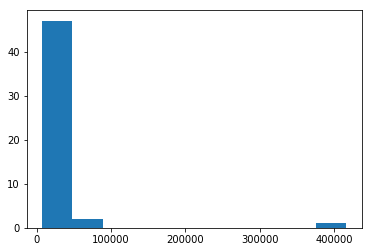

5527655


In [86]:
## Your code here
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt

# Obtain the total number of words.
num_total_words = len(words)

# Unique words.
unique_words = list(set(words))

# Count the number of occurences of each word.
# Each word in the corpus is replaced by the number of times it occurs.
word_counts = Counter(words)

# Obtain the actual number of unique occurences.
counts_of_words = list(set([word_counts[word] for word in words]))

# Sort the occurences and list the top 50.
sorted_counts_of_words = sorted(counts_of_words)

# Visualize the top 50.
plt.hist(counts_of_words[-51:-1], bins=10)
axes = plt.gca()
plt.show()

# The threshold for discarding words.
discard_threshold = 1e-5

np.random.seed(0)
# Create a dictionary which maps a word to its frequency in the corpus.
word_frequency = {word: count/num_total_words for word,count in word_counts.items()}

# Create a dicationary which computes the drop probabilitiy for a word in the corpus.
# Function defined in paper.
drop_prob = {word: 1 - np.sqrt(discard_threshold/word_frequency[word]) for word in word_counts}
# Function in implementation
# drop_prob = {word: (word_frequency[word] - discard_threshold)/word_frequency[word] - np.sqrt(discard_threshold/word_frequency[word]) for word in word_counts}

# Filter the corpus.
train_words = [word for word in int_words if np.random.random() < (1 - drop_prob[int_to_vocab[word]])]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [102]:
# def get_target(words, idx, window_size=5):
#     ''' Get a list of words in a window around an index. '''
#     np.random.seed(0)
#     # Get the number of words to keep in the window.
#     R = np.random.randint(1, window_size+1)
    
#     # Obtain the relevant indices.
#     indices_of_interest = [index + idx for index in range(-R,R+1) if index != 0]
    
#     target_words = []
#     for index in indices_of_interest:
#         target_words.append(words[index])
#     return list(set(target_words))
# print(train_words[0:20])

# print(get_target(train_words, 10))

def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)

    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [103]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [104]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, shape=[None], name='inputs')
    labels = tf.placeholder(tf.int32, shape=[None, 1], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [106]:
n_vocab = len(int_to_vocab)
n_embedding =  200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))# create embedding weight matrix here
    embed = tf.nn.embedding_lookup(embedding, inputs)# use tf.nn.embedding_lookup to get the hidden layer output

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [110]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))# create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros(n_vocab))# create softmax biases here
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab) 
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [112]:
import random
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [113]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [114]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.7548 0.0173 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6854 0.0136 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.5983 0.0137 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.5518 0.0140 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.6458 0.0136 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5621 0.0142 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.6189 0.0138 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5682 0.0138 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.5467 0.0137 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.5501 0.0137 sec/batch
Nearest to history: aldrich, testosterone, bruce, shipyard, duc, mai, flight, baccio,
Nearest to as: richthofen, groot, leonov, brilliantly, mccall, multiplication, gaeltacht, megabits,
Nearest to there: marsh, eustace, compliment, biasing, fai, krautrock, calorimeter, intervened,
Nearest to use: d

Epoch 1/10 Iteration: 4100 Avg. Training loss: 4.6140 0.0142 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 4.6226 0.0139 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 4.5683 0.0140 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 4.5767 0.0140 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 4.6013 0.0142 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 4.6025 0.0138 sec/batch
Epoch 1/10 Iteration: 4700 Avg. Training loss: 4.5367 0.0144 sec/batch
Epoch 1/10 Iteration: 4800 Avg. Training loss: 4.5562 0.0140 sec/batch
Epoch 1/10 Iteration: 4900 Avg. Training loss: 4.5726 0.0139 sec/batch
Epoch 1/10 Iteration: 5000 Avg. Training loss: 4.5619 0.0139 sec/batch
Nearest to history: bruce, aldrich, testosterone, referents, late, shipyard, flight, durbin,
Nearest to as: groot, richthofen, gaeltacht, haitian, determinism, rectify, subtraction, crusades,
Nearest to there: compliment, intervened, radii, eustace, biasing, marsh, neural, artery,
Nearest 

Epoch 2/10 Iteration: 8100 Avg. Training loss: 4.2582 0.0144 sec/batch
Epoch 2/10 Iteration: 8200 Avg. Training loss: 4.2933 0.0135 sec/batch
Epoch 2/10 Iteration: 8300 Avg. Training loss: 4.2790 0.0136 sec/batch
Epoch 2/10 Iteration: 8400 Avg. Training loss: 4.2996 0.0138 sec/batch
Epoch 2/10 Iteration: 8500 Avg. Training loss: 4.2831 0.0135 sec/batch
Epoch 2/10 Iteration: 8600 Avg. Training loss: 4.2893 0.0137 sec/batch
Epoch 2/10 Iteration: 8700 Avg. Training loss: 4.2036 0.0137 sec/batch
Epoch 2/10 Iteration: 8800 Avg. Training loss: 4.2614 0.0138 sec/batch
Epoch 2/10 Iteration: 8900 Avg. Training loss: 4.2733 0.0140 sec/batch
Epoch 2/10 Iteration: 9000 Avg. Training loss: 4.2320 0.0141 sec/batch
Nearest to history: bruce, referents, aldrich, late, durbin, clade, qaida, fleury,
Nearest to as: groot, amr, duquette, haitian, brochures, gaeltacht, cygnus, reminders,
Nearest to there: wir, painful, intervened, antebellum, calorimeter, oro, stressful, biasing,
Nearest to use: obsidian, 

Epoch 3/10 Iteration: 12100 Avg. Training loss: 4.1531 0.0146 sec/batch
Epoch 3/10 Iteration: 12200 Avg. Training loss: 4.1328 0.0140 sec/batch
Epoch 3/10 Iteration: 12300 Avg. Training loss: 4.1476 0.0137 sec/batch
Epoch 3/10 Iteration: 12400 Avg. Training loss: 4.0522 0.0137 sec/batch
Epoch 3/10 Iteration: 12500 Avg. Training loss: 4.1143 0.0138 sec/batch
Epoch 3/10 Iteration: 12600 Avg. Training loss: 4.0822 0.0139 sec/batch
Epoch 3/10 Iteration: 12700 Avg. Training loss: 4.0825 0.0137 sec/batch
Epoch 3/10 Iteration: 12800 Avg. Training loss: 4.1050 0.0136 sec/batch
Epoch 3/10 Iteration: 12900 Avg. Training loss: 4.1025 0.0137 sec/batch
Epoch 3/10 Iteration: 13000 Avg. Training loss: 4.1227 0.0138 sec/batch
Nearest to history: bruce, late, referents, articles, studies, detailed, usemodwiki, ahn,
Nearest to as: its, amr, subtraction, duquette, means, crusades, embracing, reminders,
Nearest to there: wir, stressful, destination, swordsmiths, fertile, zebra, thereabouts, neural,
Neares

Epoch 3/10 Iteration: 16100 Avg. Training loss: 3.9554 0.0143 sec/batch
Epoch 3/10 Iteration: 16200 Avg. Training loss: 4.0386 0.0140 sec/batch
Epoch 3/10 Iteration: 16300 Avg. Training loss: 4.0625 0.0139 sec/batch
Epoch 3/10 Iteration: 16400 Avg. Training loss: 4.0803 0.0139 sec/batch
Epoch 3/10 Iteration: 16500 Avg. Training loss: 4.0708 0.0138 sec/batch
Epoch 4/10 Iteration: 16600 Avg. Training loss: 4.0810 0.0028 sec/batch
Epoch 4/10 Iteration: 16700 Avg. Training loss: 4.0111 0.0137 sec/batch
Epoch 4/10 Iteration: 16800 Avg. Training loss: 3.9952 0.0138 sec/batch
Epoch 4/10 Iteration: 16900 Avg. Training loss: 4.0005 0.0138 sec/batch
Epoch 4/10 Iteration: 17000 Avg. Training loss: 4.0418 0.0138 sec/batch
Nearest to history: bruce, late, detailed, studies, articles, documenting, usemodwiki, referents,
Nearest to as: amr, its, embracing, cygnus, carolingians, crusades, groot, haitian,
Nearest to there: wir, painful, camels, householder, thereabouts, swordsmiths, macclesfield, inhum

Epoch 4/10 Iteration: 20100 Avg. Training loss: 4.0061 0.0143 sec/batch
Epoch 4/10 Iteration: 20200 Avg. Training loss: 4.0071 0.0138 sec/batch
Epoch 4/10 Iteration: 20300 Avg. Training loss: 4.0235 0.0139 sec/batch
Epoch 4/10 Iteration: 20400 Avg. Training loss: 3.9927 0.0141 sec/batch
Epoch 4/10 Iteration: 20500 Avg. Training loss: 3.9401 0.0136 sec/batch
Epoch 4/10 Iteration: 20600 Avg. Training loss: 3.9942 0.0139 sec/batch
Epoch 4/10 Iteration: 20700 Avg. Training loss: 3.9972 0.0139 sec/batch
Epoch 4/10 Iteration: 20800 Avg. Training loss: 3.9501 0.0138 sec/batch
Epoch 4/10 Iteration: 20900 Avg. Training loss: 3.9966 0.0139 sec/batch
Epoch 4/10 Iteration: 21000 Avg. Training loss: 4.0759 0.0141 sec/batch
Nearest to history: bruce, detailed, studies, articles, late, documenting, historical, peoples,
Nearest to as: cygnus, its, and, amr, crusades, groot, richthofen, carolingians,
Nearest to there: macclesfield, no, wir, households, swordsmiths, painful, thereabouts, householder,
Ne

Epoch 5/10 Iteration: 24100 Avg. Training loss: 3.9633 0.0143 sec/batch
Epoch 5/10 Iteration: 24200 Avg. Training loss: 3.9444 0.0137 sec/batch
Epoch 5/10 Iteration: 24300 Avg. Training loss: 3.9003 0.0136 sec/batch
Epoch 5/10 Iteration: 24400 Avg. Training loss: 3.9994 0.0137 sec/batch
Epoch 5/10 Iteration: 24500 Avg. Training loss: 3.9757 0.0137 sec/batch
Epoch 5/10 Iteration: 24600 Avg. Training loss: 3.8824 0.0137 sec/batch
Epoch 5/10 Iteration: 24700 Avg. Training loss: 3.9359 0.0137 sec/batch
Epoch 5/10 Iteration: 24800 Avg. Training loss: 3.9458 0.0138 sec/batch
Epoch 5/10 Iteration: 24900 Avg. Training loss: 3.9189 0.0137 sec/batch
Epoch 5/10 Iteration: 25000 Avg. Training loss: 3.9710 0.0139 sec/batch
Nearest to history: bruce, detailed, articles, studies, documenting, historical, usemodwiki, late,
Nearest to as: and, its, a, the, cygnus, was, amr, coined,
Nearest to there: no, wir, that, households, thereabouts, have, macclesfield, every,
Nearest to use: regulated, lines, enc

Epoch 6/10 Iteration: 28100 Avg. Training loss: 3.9402 0.0142 sec/batch
Epoch 6/10 Iteration: 28200 Avg. Training loss: 3.8755 0.0137 sec/batch
Epoch 6/10 Iteration: 28300 Avg. Training loss: 3.8957 0.0139 sec/batch
Epoch 6/10 Iteration: 28400 Avg. Training loss: 3.9018 0.0140 sec/batch
Epoch 6/10 Iteration: 28500 Avg. Training loss: 3.8392 0.0135 sec/batch
Epoch 6/10 Iteration: 28600 Avg. Training loss: 3.9061 0.0135 sec/batch
Epoch 6/10 Iteration: 28700 Avg. Training loss: 3.9596 0.0139 sec/batch
Epoch 6/10 Iteration: 28800 Avg. Training loss: 3.9166 0.0139 sec/batch
Epoch 6/10 Iteration: 28900 Avg. Training loss: 3.8927 0.0138 sec/batch
Epoch 6/10 Iteration: 29000 Avg. Training loss: 3.8069 0.0136 sec/batch
Nearest to history: bruce, detailed, articles, studies, historical, documenting, accretion, plundering,
Nearest to as: and, the, a, its, in, was, cygnus, amr,
Nearest to there: no, that, have, every, households, macclesfield, thereabouts, elway,
Nearest to use: regulated, ldap, d

Epoch 6/10 Iteration: 32100 Avg. Training loss: 3.9904 0.0145 sec/batch
Epoch 6/10 Iteration: 32200 Avg. Training loss: 3.9568 0.0138 sec/batch
Epoch 6/10 Iteration: 32300 Avg. Training loss: 3.9165 0.0137 sec/batch
Epoch 6/10 Iteration: 32400 Avg. Training loss: 3.8851 0.0137 sec/batch
Epoch 6/10 Iteration: 32500 Avg. Training loss: 3.8325 0.0138 sec/batch
Epoch 6/10 Iteration: 32600 Avg. Training loss: 3.9561 0.0136 sec/batch
Epoch 6/10 Iteration: 32700 Avg. Training loss: 3.7315 0.0138 sec/batch
Epoch 6/10 Iteration: 32800 Avg. Training loss: 3.9135 0.0136 sec/batch
Epoch 6/10 Iteration: 32900 Avg. Training loss: 3.8951 0.0137 sec/batch
Epoch 6/10 Iteration: 33000 Avg. Training loss: 3.8863 0.0137 sec/batch
Nearest to history: detailed, bruce, studies, articles, historical, documenting, accretion, peoples,
Nearest to as: a, the, and, in, often, also, its, has,
Nearest to there: have, no, of, that, are, households, every, non,
Nearest to use: ldap, lines, earliest, uparrow, regulated

Epoch 7/10 Iteration: 36100 Avg. Training loss: 3.8955 0.0145 sec/batch
Epoch 7/10 Iteration: 36200 Avg. Training loss: 3.8888 0.0136 sec/batch
Epoch 7/10 Iteration: 36300 Avg. Training loss: 3.8516 0.0137 sec/batch
Epoch 7/10 Iteration: 36400 Avg. Training loss: 3.8670 0.0138 sec/batch
Epoch 7/10 Iteration: 36500 Avg. Training loss: 3.8728 0.0143 sec/batch
Epoch 7/10 Iteration: 36600 Avg. Training loss: 3.8955 0.0138 sec/batch
Epoch 7/10 Iteration: 36700 Avg. Training loss: 3.8819 0.0137 sec/batch
Epoch 7/10 Iteration: 36800 Avg. Training loss: 3.8735 0.0146 sec/batch
Epoch 7/10 Iteration: 36900 Avg. Training loss: 3.8648 0.0142 sec/batch
Epoch 7/10 Iteration: 37000 Avg. Training loss: 3.8892 0.0137 sec/batch
Nearest to history: detailed, bruce, peoples, studies, historical, timeline, articles, documenting,
Nearest to as: a, the, and, in, also, often, has, to,
Nearest to there: have, no, every, that, of, are, non, households,
Nearest to use: ldap, regulated, earliest, stiles, lines, t

Epoch 8/10 Iteration: 40100 Avg. Training loss: 3.7025 0.0144 sec/batch
Epoch 8/10 Iteration: 40200 Avg. Training loss: 3.8234 0.0140 sec/batch
Epoch 8/10 Iteration: 40300 Avg. Training loss: 3.8317 0.0137 sec/batch
Epoch 8/10 Iteration: 40400 Avg. Training loss: 3.7961 0.0137 sec/batch
Epoch 8/10 Iteration: 40500 Avg. Training loss: 3.8384 0.0137 sec/batch
Epoch 8/10 Iteration: 40600 Avg. Training loss: 3.8424 0.0138 sec/batch
Epoch 8/10 Iteration: 40700 Avg. Training loss: 3.8407 0.0137 sec/batch
Epoch 8/10 Iteration: 40800 Avg. Training loss: 3.7989 0.0135 sec/batch
Epoch 8/10 Iteration: 40900 Avg. Training loss: 3.8336 0.0137 sec/batch
Epoch 8/10 Iteration: 41000 Avg. Training loss: 3.9284 0.0137 sec/batch
Nearest to history: detailed, bruce, articles, historical, studies, article, peoples, timeline,
Nearest to as: the, a, and, in, also, of, to, which,
Nearest to there: have, no, that, of, are, every, non, made,
Nearest to use: used, ldap, earliest, filler, stiles, transfered, line

Epoch 8/10 Iteration: 44100 Avg. Training loss: 3.8159 0.0145 sec/batch
Epoch 8/10 Iteration: 44200 Avg. Training loss: 3.8765 0.0137 sec/batch
Epoch 9/10 Iteration: 44300 Avg. Training loss: 3.8547 0.0118 sec/batch
Epoch 9/10 Iteration: 44400 Avg. Training loss: 3.8462 0.0140 sec/batch
Epoch 9/10 Iteration: 44500 Avg. Training loss: 3.8051 0.0138 sec/batch
Epoch 9/10 Iteration: 44600 Avg. Training loss: 3.8300 0.0143 sec/batch
Epoch 9/10 Iteration: 44700 Avg. Training loss: 3.8563 0.0145 sec/batch
Epoch 9/10 Iteration: 44800 Avg. Training loss: 3.7887 0.0155 sec/batch
Epoch 9/10 Iteration: 44900 Avg. Training loss: 3.8496 0.0162 sec/batch
Epoch 9/10 Iteration: 45000 Avg. Training loss: 3.8049 0.0161 sec/batch
Nearest to history: historical, detailed, bruce, peoples, article, articles, studies, timeline,
Nearest to as: the, and, a, in, of, to, also, which,
Nearest to there: have, no, of, are, that, every, and, is,
Nearest to use: used, ldap, earliest, some, as, addition, filler, stiles

Epoch 9/10 Iteration: 48200 Avg. Training loss: 3.8354 0.0133 sec/batch
Epoch 9/10 Iteration: 48300 Avg. Training loss: 3.7852 0.0133 sec/batch
Epoch 9/10 Iteration: 48400 Avg. Training loss: 3.8879 0.0135 sec/batch
Epoch 9/10 Iteration: 48500 Avg. Training loss: 3.7913 0.0134 sec/batch
Epoch 9/10 Iteration: 48600 Avg. Training loss: 3.9491 0.0136 sec/batch
Epoch 9/10 Iteration: 48700 Avg. Training loss: 3.8706 0.0148 sec/batch
Epoch 9/10 Iteration: 48800 Avg. Training loss: 3.9149 0.0157 sec/batch
Epoch 9/10 Iteration: 48900 Avg. Training loss: 3.8116 0.0143 sec/batch
Epoch 9/10 Iteration: 49000 Avg. Training loss: 3.8021 0.0137 sec/batch
Nearest to history: detailed, historical, timeline, articles, article, peoples, bruce, studies,
Nearest to as: the, and, a, in, of, to, also, was,
Nearest to there: have, no, are, of, that, every, this, made,
Nearest to use: used, ldap, stiles, addition, as, however, lines, tifinagh,
Nearest to s: in, and, the, nine, of, on, with, a,
Nearest to their

Epoch 10/10 Iteration: 52400 Avg. Training loss: 3.7892 0.0133 sec/batch
Epoch 10/10 Iteration: 52500 Avg. Training loss: 3.8328 0.0133 sec/batch
Epoch 10/10 Iteration: 52600 Avg. Training loss: 3.8101 0.0130 sec/batch
Epoch 10/10 Iteration: 52700 Avg. Training loss: 3.8137 0.0131 sec/batch
Epoch 10/10 Iteration: 52800 Avg. Training loss: 3.8622 0.0132 sec/batch
Epoch 10/10 Iteration: 52900 Avg. Training loss: 3.7438 0.0131 sec/batch
Epoch 10/10 Iteration: 53000 Avg. Training loss: 3.8694 0.0130 sec/batch
Nearest to history: article, historical, detailed, articles, links, bruce, see, peoples,
Nearest to as: a, the, in, of, and, to, also, other,
Nearest to there: have, of, are, no, that, every, is, this,
Nearest to use: used, as, addition, some, however, stiles, lines, earliest,
Nearest to s: in, nine, the, and, on, a, of, by,
Nearest to their: they, and, own, all, to, with, make, other,
Nearest to can: example, here, secretes, is, may, if, afp, to,
Nearest to see: also, external, list,

Restore the trained network if you need to:

In [115]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [116]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [117]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

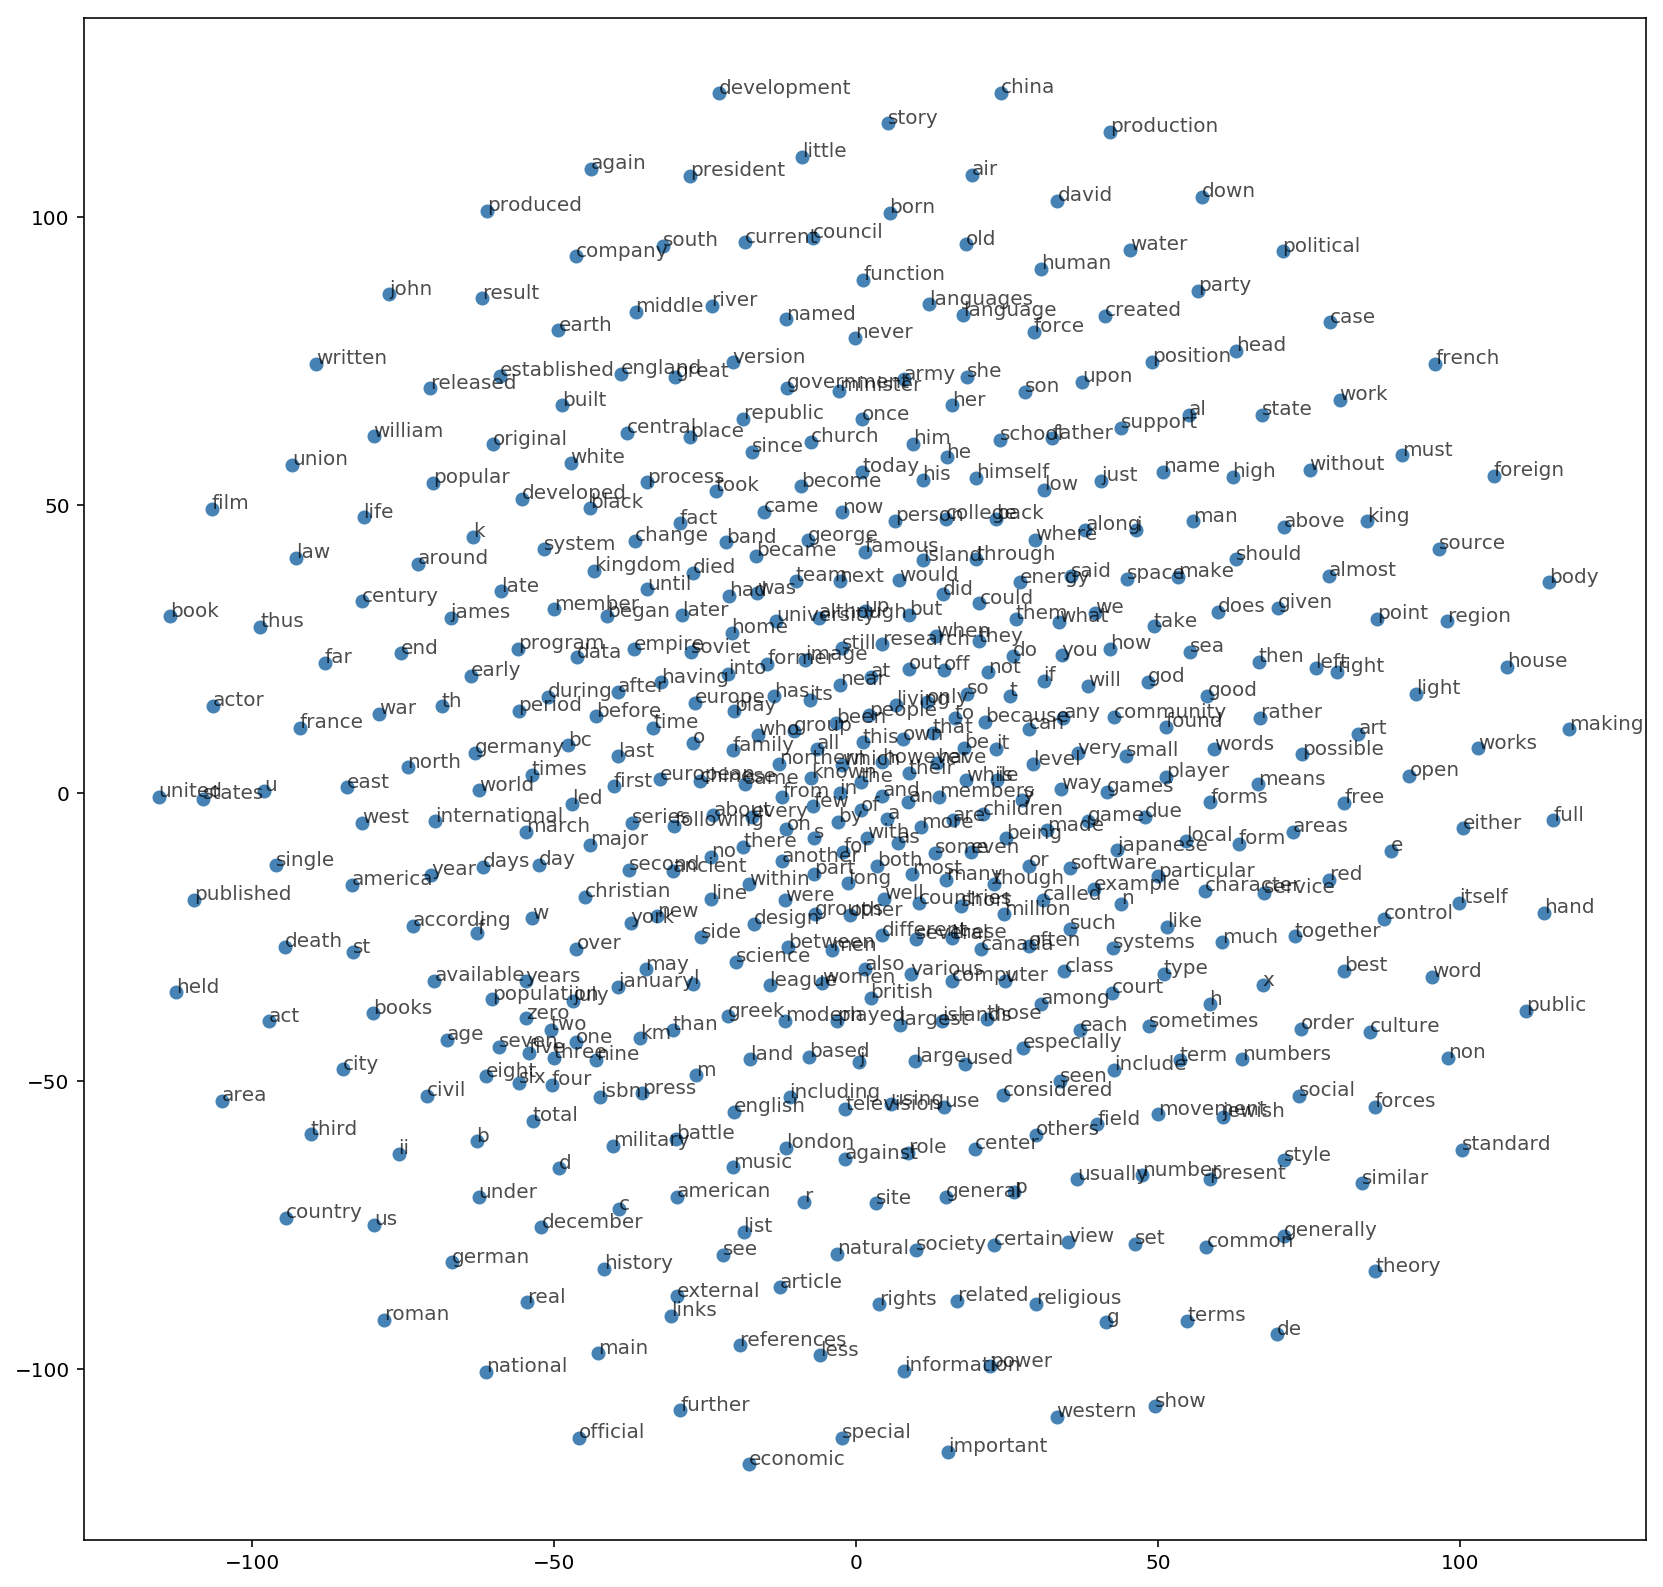

In [118]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [3]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant(-1.0, shape=[10000,10000])
    b = tf.constant(5.0, shape=[10000,10000])
    c = tf.matmul(a, b)

with tf.Session() as sess:
    value = sess.run(c)
    print(value[0][0])

-50000.0
